In [1]:
import torch
import pickle as pkl
from pathlib import Path

In [4]:
!pip install torch-utils

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for torch-utils, since package 'wheel' is not installed.
  Running setup.py install for torch-utils: started
  Running setup.py install for torch-utils: finished with status 'done'


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


# BALANCED AT DIFFERENT THRESHOLDS 

In [5]:
with open(("data/descriptors_dict_threshold_1_through_10.pkl"), 'rb') as f:
    # Load the object from the pickle file
    descriptors_dict = pkl.load(f)
    TRAIN_SIZE = len(descriptors_dict["train_images"][1])
descriptors_dict.keys()

ModuleNotFoundError: No module named 'torch._utils'

In [5]:
for i in range (1, 10): 
    train_labels = descriptors_dict["train_labels"][i]
    train_images = descriptors_dict["train_images"][i]
    a = len(train_labels)
    b = train_labels.sum()
    print(f"threshold {i} pos rate: {b}/{a}")

threshold 1 pos rate: 1550/15300
threshold 2 pos rate: 1470/15300
threshold 3 pos rate: 1430/15300
threshold 4 pos rate: 1400/15300
threshold 5 pos rate: 1380/15300
threshold 6 pos rate: 1340/15300
threshold 7 pos rate: 1270/15300
threshold 8 pos rate: 1240/15300
threshold 9 pos rate: 1200/15300


In [4]:
for i in range (1, 10): 
    train_labels = descriptors_dict["test_labels"][i]
    train_images = descriptors_dict["test_images"][i]
    a = len(train_labels)
    b = train_labels.sum()
    print(f"threshold {i} pos rate: {b}/{a}")

threshold 1 pos rate: 49/510
threshold 2 pos rate: 47/510
threshold 3 pos rate: 45/510
threshold 4 pos rate: 43/510
threshold 5 pos rate: 42/510
threshold 6 pos rate: 41/510
threshold 7 pos rate: 39/510
threshold 8 pos rate: 38/510
threshold 9 pos rate: 38/510


In [4]:
from sklearn.utils import resample

def getBalancedXy(X, y, replacement=True):
    # Find the indices of positive and negative samples
    pos_indices = (y == 1).nonzero(as_tuple=True)[0]
    neg_indices = (y == 0).nonzero(as_tuple=True)[0]

    # Undersample the majority class or oversample the minority class
    if len(pos_indices) > len(neg_indices):
        # Undersample the positive samples
        neg_indices_upsampled = resample(neg_indices, replace=replacement, n_samples=len(pos_indices))
        indices = torch.cat((pos_indices, neg_indices_upsampled))
    else:
        # Oversample the negative samples
        pos_indices_upsampled = resample(pos_indices, replace=replacement, n_samples=len(neg_indices))
        indices = torch.cat((pos_indices_upsampled, neg_indices))

    # Create a balanced dataset using the selected indices
    balanced_X = X[indices]
    balanced_y = y[indices]

    return balanced_X, balanced_y



In [ ]:
# going through training set and oversampling to balance 
for i in range (1, 10): 
    # checking pos/neg-ratio before balancing
    train_labels = descriptors_dict["train_labels"][i]
    train_images = descriptors_dict["train_images"][i]
    a = len(train_labels)
    b = train_labels.sum()
    print(f"threshold {i} pos rate: {b}/{a}")

    # balancing train
    descriptors_dict["train_images"][i], descriptors_dict["train_labels"][i] = getBalancedXy(train_images, train_labels)
    
    # checking pos/neg-ratio after balancing
    train_labels = descriptors_dict["train_labels"][i]
    train_images = descriptors_dict["train_images"][i]
    a = len(train_labels)
    b = train_labels.sum()
    print(f"threshold {i} pos rate: {b}/{a} after balancing")


In [ ]:
#XGBOOST
import xgboost as xgb
import time 

def train_and_get_test_metrics(train_images, train_labels, test_images, test_labels):
    model = xgb.XGBClassifier()

    start_time = time.perf_counter()

    model.fit(train_images, train_labels) #For sklearn no one hot encoding

    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    print(f"Training time: {elapsed_time:.6f} seconds")
    
    #Now predict using the trained RF model. 
    prediction = model.predict(test_images)
    #Print overall accuracy
    #Print overall accuracy
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))
    f1 = metrics.f1_score(test_labels, prediction)
    print ("F1 = ", f1)
    print ("CM: ")
    print(confusion_matrix(test_labels, prediction))
    return f1

In [43]:
for i in range (1, 10): 
    train_labels = descriptors_dict["train_labels"][i]
    train_images = descriptors_dict["train_images"][i]

    test_labels = descriptors_dict["test_labels"][i]
    test_images = descriptors_dict["test_images"][i]

    train_and_get_test_metrics(train_images, train_labels, test_images, test_labels)

Training time: 532.134625 seconds
Accuracy =  0.9098039215686274
F1 =  0.46511627906976744
CM: 
[[444  17]
 [ 29  20]]
Training time: 452.457605 seconds
Accuracy =  0.9215686274509803
F1 =  0.48717948717948717
CM: 
[[451  12]
 [ 28  19]]
Training time: 451.194482 seconds
Accuracy =  0.9176470588235294
F1 =  0.4615384615384615
CM: 
[[450  15]
 [ 27  18]]
Training time: 465.395445 seconds
Accuracy =  0.9254901960784314
F1 =  0.5
CM: 
[[453  14]
 [ 24  19]]
Training time: 463.691830 seconds
Accuracy =  0.9196078431372549
F1 =  0.4383561643835616
CM: 
[[453  15]
 [ 26  16]]
Training time: 443.872172 seconds
Accuracy =  0.9313725490196079
F1 =  0.5205479452054794
CM: 
[[456  13]
 [ 22  19]]
Training time: 465.811852 seconds
Accuracy =  0.9352941176470588
F1 =  0.5352112676056338
CM: 
[[458  13]
 [ 20  19]]
Training time: 421.925210 seconds
Accuracy =  0.9411764705882353
F1 =  0.5454545454545454
CM: 
[[462  10]
 [ 20  18]]
Training time: 411.746596 seconds
Accuracy =  0.9411764705882353
F1 =

# BALANCED AT DIFFERENT THRESHOLDS AND SEEING PROGRESS AS MORE AND MORE TRAINING DATA IS ADDED 

In [ ]:
def shuffle_tensors_in_same_order(tensor1, tensor2):
    perm = torch.randperm(len(tensor1))

    shuffled1 = tensor1[perm]
    shuffled2 = tensor2[perm]

    return shuffled1, shuffled2

from sklearn.utils import resample
def getBalancedXy(X, y, replacement=True):
    # Find the indices of positive and negative samples
    pos_indices = (y == 1).nonzero(as_tuple=True)[0]
    neg_indices = (y == 0).nonzero(as_tuple=True)[0]

    if len(pos_indices) == 0 or len(neg_indices) == 0: 
        print("THIS IS NO BUENO !!!!! there are either no pos or neg in this slice")

    # Undersample the majority class or oversample the minority class
    if len(pos_indices) > len(neg_indices):
        # Undersample the positive samples
        neg_indices_upsampled = resample(neg_indices, replace=replacement, n_samples=len(pos_indices))
        indices = torch.cat((pos_indices, neg_indices_upsampled))
    else:
        # Oversample the negative samples
        pos_indices_upsampled = resample(pos_indices, replace=replacement, n_samples=len(neg_indices))
        indices = torch.cat((pos_indices_upsampled, neg_indices))

    # Create a balanced dataset using the selected indices
    balanced_X = X[indices]
    balanced_y = y[indices]

    return balanced_X, balanced_y

def getTrainShuffled_andTestUnshuffled(threshold):
    with open(("data/descriptors_dict_threshold_1_through_10.pkl"), 'rb') as f:
        # Load the object from the pickle file
        descriptors_dict = pkl.load(f)

    # iterate ten times starting with 10% of training data, balancing it and training it, then 20%, then 30%.... Only do it for 2 or 3 thresholds though
    train_labels = descriptors_dict["train_labels"][1]
    train_images = descriptors_dict["train_images"][1]

    train_images, train_labels = shuffle_tensors_in_same_order(train_images, train_labels)

    test_labels = descriptors_dict["test_labels"][1]
    test_images = descriptors_dict["test_images"][1]

    return train_images, train_labels, test_images, test_labels

def getF1sForThreshold(threshold, num_f1s, trainsizes):
    f1_dict_by_trainsize = {}
    for trainsize in trainsizes: 
        f1s = []
        for _ in range(num_f1s):
            train_images, train_labels, test_images, test_labels = getTrainShuffled_andTestUnshuffled(threshold)
            train_images_, train_labels_ = getBalancedXy(train_images[0:trainsize], train_labels[0:trainsize])
            f1 = train_and_get_test_metrics(train_images_, train_labels_, test_images, test_labels)
            f1s.append(f1)

        f1_dict_by_trainsize[trainsize] = f1s
    return f1_dict_by_trainsize

# getting sizes of 20, 40, 60, 80, 100% of training data
trainsizes = []
for i in [2,4,6,8,10]: 
    slice_end = int(TRAIN_SIZE * 0.1*i)
    if slice_end >= TRAIN_SIZE: 
        print("slide_end bigger than train_images len: ", TRAIN_SIZE)
        slice_end = TRAIN_SIZE - 1
    trainsizes.append(slice_end)

slide_end bigger than train_images len:  15300


In [ ]:
threshold1_f1s = getF1sForThreshold(1, 5, trainsizes)
import pickle

# Save threshold1_f1s as a pickle file
with open('threshold1_f1s.pkl', 'wb') as f:
    pickle.dump(threshold1_f1s, f)

: 

In [47]:
threshold9_f1s = getF1sForThreshold(9, 5, trainsizes)

# Save threshold9_f1s as a pickle file
with open('threshold9_f1s.pkl', 'wb') as f:
    pickle.dump(threshold9_f1s, f)

Training time: 64.879049 seconds
Accuracy =  0.9098039215686274
F1 =  0.3947368421052632
CM: 
[[449  12]
 [ 34  15]]
Training time: 64.211108 seconds
Accuracy =  0.9254901960784314
F1 =  0.5365853658536586
CM: 
[[450  11]
 [ 27  22]]
Training time: 61.376516 seconds
Accuracy =  0.9137254901960784
F1 =  0.40540540540540543
CM: 
[[451  10]
 [ 34  15]]
Training time: 61.744323 seconds
Accuracy =  0.9196078431372549
F1 =  0.45333333333333325
CM: 
[[452   9]
 [ 32  17]]
Training time: 70.097265 seconds
Accuracy =  0.9215686274509803
F1 =  0.47368421052631576
CM: 
[[452   9]
 [ 31  18]]
Training time: 152.345923 seconds
Accuracy =  0.9117647058823529
F1 =  0.43037974683544306
CM: 
[[448  13]
 [ 32  17]]
Training time: 160.214339 seconds
Accuracy =  0.9196078431372549
F1 =  0.4938271604938272
CM: 
[[449  12]
 [ 29  20]]
Training time: 159.743001 seconds
Accuracy =  0.9137254901960784
F1 =  0.4634146341463415
CM: 
[[447  14]
 [ 30  19]]
Training time: 161.185593 seconds
Accuracy =  0.921568627

# Plotting

In [1]:
import matplotlib.pyplot as plt

def plot_f1_scores(F1_scores, training_sizes, title):
    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.plot(training_sizes, F1_scores)
    ax.set_xlabel('Training Size')
    ax.set_ylabel('F1 Score')
    plt.show()

In [2]:
import pickle as pkl 
with open(("threshold1_f1s.pkl"), 'rb') as f:
    # Load the object from the pickle file
    threshold1_f1s = pkl.load(f)  

threshold1_f1s.keys()

dict_keys(['trainsize'])

In [38]:
for i in fs: 
    slice_end = int(len(train_images) * 0.1*i)
    if slice_end >= len(train_images): 
        print("slide_end bigger than train_images len: ", len(train_images))
        slice_end = len(train_images) - 1
    print(f"slice_start: {0}, slice_end: {slice_end}")
    train_images_, train_labels_ = getBalancedXy(train_images[0:slice_end], train_labels[0:slice_end])

    for j in range(5):
        f1 = train_and_get_test_metrics(train_images_, train_labels_, test_images, test_labels)
        threshold1_f1_scores.append(f1)

slice_start: 0, slice_end: 3060


KeyboardInterrupt: 

In [ ]:
with open(("data/descriptors_dict_threshold_1_through_10.pkl"), 'rb') as f:
    # Load the object from the pickle file
    descriptors_dict = pkl.load(f)

# iterate ten times starting with 10% of training data, balancing it and training it, then 20%, then 30%.... Only do it for 2 or 3 thresholds though
train_labels = descriptors_dict["train_labels"][9]
train_images = descriptors_dict["train_images"][9]

test_labels = descriptors_dict["test_labels"][9]
test_images = descriptors_dict["test_images"][9]

del descriptors_dict

threshold9_f1_scores = []
fs = [2, 4, 6, 8, 10]
for i in fs: 
    slice_end = int(len(train_images) * 0.1*i)
    if slice_end >= len(train_images): 
        print("slide_end bigger than train_images len: ", len(train_images))
        slice_end = len(train_images) - 1
    print(f"slice_start: {0}, slice_end: {slice_end}")
    train_images_, train_labels_ = getBalancedXy(train_images[0:slice_end], train_labels[0:slice_end])

    for j in range(5):
        f1 = train_and_get_test_metrics(train_images_, train_labels_, test_images, test_labels)
        threshold9_f1_scores.append(f1)

slice_start: 0, slice_end: 3060
Training time: 58.517289 seconds
Accuracy =  0.9196078431372549
F1 =  0.36923076923076925
CM: 
[[457  15]
 [ 26  12]]
slice_start: 0, slice_end: 6120
Training time: 191.951175 seconds
Accuracy =  0.9294117647058824
F1 =  0.47058823529411764
CM: 
[[458  14]
 [ 22  16]]
slice_start: 0, slice_end: 9180
Training time: 308.073535 seconds
Accuracy =  0.9196078431372549
F1 =  0.4383561643835617
CM: 
[[453  19]
 [ 22  16]]
slice_start: 0, slice_end: 12240
Training time: 455.810008 seconds
Accuracy =  0.9235294117647059
F1 =  0.43478260869565216
CM: 
[[456  16]
 [ 23  15]]
slide_end bigger than train_images len:  15300
slice_start: 0, slice_end: 15299
Training time: 571.260923 seconds
Accuracy =  0.9352941176470588
F1 =  0.5217391304347826
CM: 
[[459  13]
 [ 20  18]]


# Trying again, but shuffled to see if similar results

In [26]:
with open(("data/descriptors_dict_threshold_1_through_10.pkl"), 'rb') as f:
    # Load the object from the pickle file
    descriptors_dict = pkl.load(f)

from sklearn.utils import resample
def getBalancedXy(X, y, replacement=True):
    # Find the indices of positive and negative samples
    pos_indices = (y == 1).nonzero(as_tuple=True)[0]
    neg_indices = (y == 0).nonzero(as_tuple=True)[0]

    if len(pos_indices) == 0 or len(neg_indices) == 0: 
        print("THIS IS NO BUENO !!!!! there are either no pos or neg in this slice")

    # Undersample the majority class or oversample the minority class
    if len(pos_indices) > len(neg_indices):
        # Undersample the positive samples
        neg_indices_upsampled = resample(neg_indices, replace=replacement, n_samples=len(pos_indices))
        indices = torch.cat((pos_indices, neg_indices_upsampled))
    else:
        # Oversample the negative samples
        pos_indices_upsampled = resample(pos_indices, replace=replacement, n_samples=len(neg_indices))
        indices = torch.cat((pos_indices_upsampled, neg_indices))

    # Create a balanced dataset using the selected indices
    balanced_X = X[indices]
    balanced_y = y[indices]

    return balanced_X, balanced_y

# iterate ten times starting with 10% of training data, balancing it and training it, then 20%, then 30%.... Only do it for 2 or 3 thresholds though
train_labels = descriptors_dict["train_labels"][1]
train_images = descriptors_dict["train_images"][1]

train_images, train_labels = shuffle_tensors_in_same_order(train_images, train_labels)

test_labels = descriptors_dict["test_labels"][1]
test_images = descriptors_dict["test_images"][1]

del descriptors_dict

fs = [2, 4, 6, 8, 10]
for i in fs: 
    slice_end = int(len(train_images) * 0.1*i)
    if slice_end >= len(train_images): 
        print("slide_end bigger than train_images len: ", len(train_images))
        slice_end = len(train_images) - 1
    print(f"slice_start: {0}, slice_end: {slice_end}")
    train_images_, train_labels_ = getBalancedXy(train_images[0:slice_end], train_labels[0:slice_end])

    train_and_get_test_metrics(train_images_, train_labels_, test_images, test_labels)

slice_start: 0, slice_end: 3060
Training time: 90.614602 seconds
Accuracy =  0.9156862745098039
F1 =  0.46913580246913583
CM: 
[[448  13]
 [ 30  19]]
slice_start: 0, slice_end: 6120
Training time: 229.137631 seconds
Accuracy =  0.9196078431372549
F1 =  0.5287356321839081
CM: 
[[446  15]
 [ 26  23]]
slice_start: 0, slice_end: 9180
Training time: 370.349545 seconds
Accuracy =  0.9
F1 =  0.4516129032258064
CM: 
[[438  23]
 [ 28  21]]
slice_start: 0, slice_end: 12240
Training time: 526.257920 seconds
Accuracy =  0.907843137254902
F1 =  0.4337349397590361
CM: 
[[445  16]
 [ 31  18]]
slide_end bigger than train_images len:  15300
slice_start: 0, slice_end: 15299
Training time: 691.978761 seconds
Accuracy =  0.9215686274509803
F1 =  0.5238095238095237
CM: 
[[448  13]
 [ 27  22]]


In [27]:
with open(("data/descriptors_dict_threshold_1_through_10.pkl"), 'rb') as f:
    # Load the object from the pickle file
    descriptors_dict = pkl.load(f)

from sklearn.utils import resample
def getBalancedXy(X, y, replacement=True):
    # Find the indices of positive and negative samples
    pos_indices = (y == 1).nonzero(as_tuple=True)[0]
    neg_indices = (y == 0).nonzero(as_tuple=True)[0]

    if len(pos_indices) == 0 or len(neg_indices) == 0: 
        print("THIS IS NO BUENO !!!!! there are either no pos or neg in this slice")

    # Undersample the majority class or oversample the minority class
    if len(pos_indices) > len(neg_indices):
        # Undersample the positive samples
        neg_indices_upsampled = resample(neg_indices, replace=replacement, n_samples=len(pos_indices))
        indices = torch.cat((pos_indices, neg_indices_upsampled))
    else:
        # Oversample the negative samples
        pos_indices_upsampled = resample(pos_indices, replace=replacement, n_samples=len(neg_indices))
        indices = torch.cat((pos_indices_upsampled, neg_indices))

    # Create a balanced dataset using the selected indices
    balanced_X = X[indices]
    balanced_y = y[indices]

    return balanced_X, balanced_y

# iterate ten times starting with 10% of training data, balancing it and training it, then 20%, then 30%.... Only do it for 2 or 3 thresholds though
train_labels = descriptors_dict["train_labels"][9]
train_images = descriptors_dict["train_images"][9]

train_images, train_labels = shuffle_tensors_in_same_order(train_images, train_labels)

test_labels = descriptors_dict["test_labels"][9]
test_images = descriptors_dict["test_images"][9]

del descriptors_dict

fs = [2, 4, 6, 8, 10]
for i in fs: 
    slice_end = int(len(train_images) * 0.1*i)
    if slice_end >= len(train_images): 
        print("slide_end bigger than train_images len: ", len(train_images))
        slice_end = len(train_images) - 1
    print(f"slice_start: {0}, slice_end: {slice_end}")
    train_images_, train_labels_ = getBalancedXy(train_images[0:slice_end], train_labels[0:slice_end])

    train_and_get_test_metrics(train_images_, train_labels_, test_images, test_labels)

slice_start: 0, slice_end: 3060
Training time: 81.663570 seconds
Accuracy =  0.9294117647058824
F1 =  0.45454545454545453
CM: 
[[459  13]
 [ 23  15]]
slice_start: 0, slice_end: 6120
Training time: 165.167107 seconds
Accuracy =  0.9392156862745098
F1 =  0.5079365079365079
CM: 
[[463   9]
 [ 22  16]]
slice_start: 0, slice_end: 9180
Training time: 267.211134 seconds
Accuracy =  0.9313725490196079
F1 =  0.4444444444444444
CM: 
[[461  11]
 [ 24  14]]
slice_start: 0, slice_end: 12240
Training time: 528.123044 seconds
Accuracy =  0.9333333333333333
F1 =  0.48484848484848486
CM: 
[[460  12]
 [ 22  16]]
slide_end bigger than train_images len:  15300
slice_start: 0, slice_end: 15299
Training time: 643.284431 seconds
Accuracy =  0.9274509803921569
F1 =  0.44776119402985076
CM: 
[[458  14]
 [ 23  15]]


In [30]:
threshold_1_first = [0.39999999999999997,  0.40506329113924044, 0.4444444444444445, 0.3764705882352941, 0.4827586206896552]
threshold_9_first =  [0.36923076923076925, 0.47058823529411764, 0.4383561643835617, 0.43478260869565216, 0.5217391304347826]

threshold_1_second = [0.46913580246913583, 0.5287356321839081, 0.4516129032258064, 0.4337349397590361, 0.5238095238095237]
threshold_9_second = [0.45454545454545453, 0.5079365079365079, 0.4444444444444444, 0.48484848484848486, 0.44776119402985076]

training_sizes = [3060, 6120, 9180, 12240, 15300]

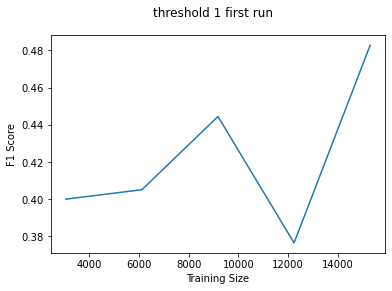

In [32]:
plot_f1_scores(threshold_1_first, training_sizes, "threshold 1 first run")

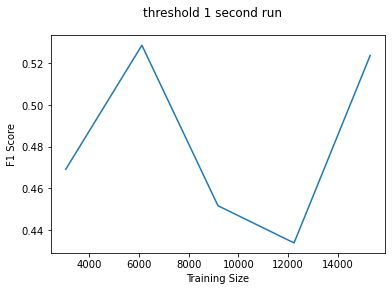

In [33]:
plot_f1_scores(threshold_1_second, training_sizes, "threshold 1 second run")

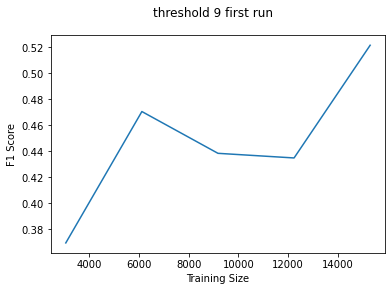

In [36]:
plot_f1_scores(threshold_9_first, training_sizes, "threshold 9 first run")

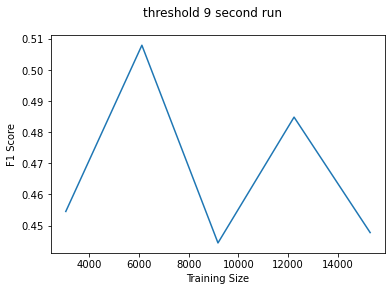

In [35]:
plot_f1_scores(threshold_9_second, training_sizes, "threshold 9 second run")